<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/ChangHyun/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 환경 설정

#### 사전에 다운 받은 패키지 불러오기

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
#os.symlink('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/reference/my_env', my_path)
sys.path.insert(0, my_path)
os.chdir('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/notebook/ChangHyun/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### matplotlib 한글 깨짐 해결 코드

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,455 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155229 files and d

해당 [사이트](https://teddylee777.github.io/colab/colab-korean)를 참고하여 위의 코드를 실행한 다음 런타임 재시작을 해주어야 합니다.

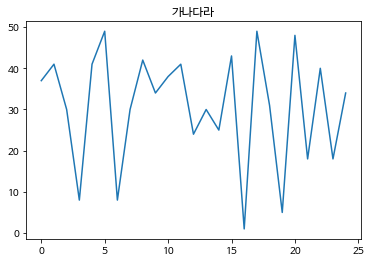

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 한글 지원 폰트
plt.rc('font', family='NanumBarunGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

plt.plot(np.random.randint(1, 50, 25))
plt.title("가나다라")
plt.show()

#### 앞으로 사용할 패키지 불러오기

In [ ]:
import re
import time
from glob import glob
from tqdm import tqdm
from packages import utils, tokenizer
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from collections import defaultdict, Counter

import tensorflow as tf
import sentencepiece as spm
from transformers import TFBertForSequenceClassification, BertTokenizer
from transformers import TextClassificationPipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## 데이터 불러오기

In [ ]:
now_path = os.getcwd()
data_path = utils.recurrent_find_data_path(now_path)
bucket_files = utils.get_data_paths(data_path)
file_dict = utils.files_to_pd_dict(bucket_files)

100%|██████████| 19/19 [00:22<00:00,  1.16s/it]


TUNiB 데이터 : sample_answersheet, test, train  
AI_HUB 데이터 : 나머지 데이터

In [ ]:
keys = list(file_dict.keys())
print(f"불러온 데이터 파일명들 : {keys}")

불러온 데이터 파일명들 : ['sample_answersheet', 'test', 'train', '여권 최종본(0416)', '상수도_최종본(0416)', '차량등록_최종본(0429)', '교통_최종본(0416)', 'A 음식점(15,726)_new', 'B 의류(15,826)_new', 'C 학원(4,773)_new', 'E 생활서비스(11,087)_new', 'G 숙박업(7,113)_new', 'I 부동산(8,131)_new', 'H 관광여가오락(4,949)_new', 'D 소매점(14,949)_new', 'F 카페(7,859)_new']


In [ ]:
print(f'위협 문장 훈련 데이터 개수 : {file_dict["train"].shape[0]}')
print(f'위협 문장 테스트 데이터 개수 : {file_dict["test"].T.shape[0]}')
file_dict["train"].head()

위협 문장 훈련 데이터 개수 : 3950
위협 문장 테스트 데이터 개수 : 400


,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


AI_HUB 일반 대화 데이터 프레임 만들기

In [ ]:
normal_conversation = []
for name in keys[3:]:
  if "SENTENCE" in file_dict[name].columns:
    normal_conversation.append(file_dict[name]["SENTENCE"])
  elif "question" in file_dict[name].columns:
    normal_conversation.append(file_dict[name]["question"])
    normal_conversation.append(file_dict[name]["answer"])

In [ ]:
normal_pd = pd.DataFrame()
normal_pd["conversation"] = pd.concat(normal_conversation)
normal_pd["class"] = "일반 대화"
normal_pd = normal_pd.reset_index(drop=True)
normal_pd = normal_pd.reset_index()
normal_pd = normal_pd.rename(columns = {"index" : "idx"})

In [ ]:
print(f'일반 문장 훈련 데이터 개수 : {normal_pd.shape[0]}')
normal_pd.head()

일반 문장 훈련 데이터 개수 : 101497


,idx,conversation,class
0,0,여권 기한이 다돼가지고 새로 재발급 해야되가지고요,일반 대화
1,1,여권 시간이 좀 돼 가지고 뭐 재 발급인가 아니면 뭐 다시 해야 될 낀데 어떻게 하...,일반 대화
2,2,여권연장 발급할라 카는데요,일반 대화
3,3,여권을 갱신하고 싶은데 거 어디로 가만 되지요,일반 대화
4,4,갱신이란 건 없습니까?,일반 대화


AI_HUB 데이터와 TUNiB 데이터를 합친 데이터 프레임 만들기

In [ ]:
train = pd.concat([file_dict["train"], normal_pd]).reset_index(drop=True)
print(f'일반 문장 훈련 데이터 개수 : {train.shape[0]}')
train.head()

일반 문장 훈련 데이터 개수 : 105447


,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


## 데이터 전처리

#### 결측데이터 제거

In [ ]:
print(f'결측 데이터 제거전 데이터 개수 : {train.shape[0]}')
train = utils.remove_nan(train).reset_index(drop=True)
print(f'결측 데이터 제거전 데이터 개수 : {train.shape[0]}')

결측 데이터 제거전 데이터 개수 : 105447
결측 데이터 제거전 데이터 개수 : 105338


#### 특수문자, 공백 제거

In [ ]:
def remove_punctuation(x):
  x = re.sub("[^ㄱ-ㅎ가-힣]+", " ", x)
  x = re.sub("[ ]+", " ", x)
  x = x.strip()
  return x

In [ ]:
train["pre_conversation"] = train["conversation"].apply(lambda x : remove_punctuation(x))
train.head()

,idx,class,conversation,pre_conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 시 분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 얘기한...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...


#### Label Encoding

In [ ]:
bucket_class = []
label_names = ["협박 대화", "갈취 대화", "직장 내 괴롭힘 대화", 
               "기타 괴롭힘 대화", "일반 대화"]

for idx, label in enumerate(train["class"]):
  if label == label_names[0]:
    bucket_class.append(0)
  elif label == label_names[1]:
    bucket_class.append(1)
  elif label == label_names[2]:
    bucket_class.append(2)
  elif label == label_names[3]:
    bucket_class.append(3)
  elif label == label_names[4]:
    bucket_class.append(4)

train["class"] = bucket_class
train.head()

,idx,class,conversation,pre_conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 시 분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 얘기한...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...


## 데이터 분석 및 시각화

협박 대화             896
갈취 대화             981
직장 내 괴롭힘 대화       979
기타 괴롭힘 대화        1094
일반 대화          101388
Name: idx, dtype: int64


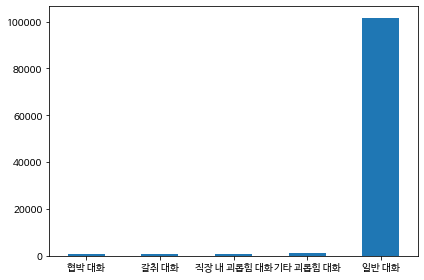

In [ ]:
group_count = train.groupby("class").count().iloc[:,0]
group_count.index = label_names
print(group_count)
group_count.plot(kind="bar")
plt.xticks(rotation = 360)
plt.tight_layout()
plt.show()

#### Under Sampling

In [ ]:
number_min_label = min(group_count)
print(f"레이블중에서 가장 개수가 작은 레이블의 개수 : {number_min_label}")

레이블중에서 가장 개수가 작은 레이블의 개수 : 896


In [ ]:
under_train = train.groupby("class").sample(number_min_label, random_state = 200)
under_train.groupby("class").count().iloc[:,0]

class
0    896
1    896
2    896
3    896
4    896
Name: idx, dtype: int64

In [ ]:
ls

baseline.ipynb        bpe_10000.tmp              packages/
baseline_KoGPT.ipynb  bpe_10000_train_spm.model  Park_json.ipynb
baseline_LSTM.ipynb   bpe_10000_train_spm.vocab


In [ ]:
under_train.to_csv("./sample_data.csv")

#### 훈련셋 검증셋 나누기

In [ ]:
X = under_train["pre_conversation"].to_list()
Y = under_train["class"].to_list()

x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, 
                                                            test_size = 0.1, 
                                                            random_state = 200,
                                                            stratify = Y)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = 0.5,
                                                random_state = 202,
                                                stratify = y_val_test)
print(f"x_train 개수 : {len(x_train)}")
print(f"y_train 개수 : {len(y_train)}")
print(f"x_val 개수 : {len(x_val)}")
print(f"y_val 개수 : {len(y_val)}")
print(f"x_test 개수 : {len(x_test)}")
print(f"y_test 개수 : {len(y_test)}")

print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")
print(f"검증 데이터 레이블 비율 확인 : {Counter(y_val)}")
print(f"테스트 데이터 레이블 비율 확인 : {Counter(y_test)}")

x_train 개수 : 4032
y_train 개수 : 4032
x_val 개수 : 224
y_val 개수 : 224
x_test 개수 : 224
y_test 개수 : 224
훈련 데이터 레이블 비율 확인 : Counter({3: 807, 4: 807, 1: 806, 0: 806, 2: 806})
검증 데이터 레이블 비율 확인 : Counter({0: 45, 2: 45, 3: 45, 1: 45, 4: 44})
테스트 데이터 레이블 비율 확인 : Counter({2: 45, 1: 45, 4: 45, 0: 45, 3: 44})


## HuggingFace torch 적용하기

참고사이트
- https://github.com/haven-jeon/KoGPT2-subtasks
- https://github.com/seawavve/newsTopicClassification

In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

#### Model setup

In [ ]:
set_seed(123)
epochs = 1
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path='skt/kogpt2-base-v2'
labels_ids = {'협박 대화':0, '갈취 대화':1,'직장 내 괴롭힘 대화':2,
              '기타 괴롭힘 대화':3,'일반 대화':4}
n_labels = len(labels_ids)
n_labels

5

In [ ]:
label_names

['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

#### Tokenizing

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

HUGGINGFACE_MODEL_PATH = "skt/kogpt2-base-v2"
num_labels = max(train["class"]) + 1
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(HUGGINGFACE_MODEL_PATH,
                                          num_labels = num_labels,
                                          bos_token='</s>', 
                                          eos_token='</s>', 
                                          unk_token='<unk>',
                                          pad_token='<pad>', 
                                          mask_token='<mask>')

In [ ]:
# Tokenizing
train_encodings = tokenizer(x_train, truncation=True, padding=True)
val_encodings = tokenizer(x_val, truncation=True, padding=True)

for key in train_encodings:
  print(f"{key} : {train_encodings[key][0]}")

reshape_y_train = np.array(y_train).reshape(-1,1)
reshape_y_val = np.array(y_val).reshape(-1,1)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


input_ids : [10364, 22044, 9018, 10410, 10278, 7661, 10401, 9198, 7888, 8234, 22126, 11676, 9177, 10452, 9831, 7285, 45847, 7235, 9170, 8676, 17458, 9024, 8238, 9217, 9078, 18952, 23971, 8041, 6921, 45887, 19588, 17458, 9241, 7283, 19588, 9074, 10211, 8022, 8084, 34072, 10364, 36089, 14017, 7991, 8263, 9022, 9150, 8517, 8135, 10070, 11186, 9094, 9122, 7182, 16238, 8084, 35268, 7791, 10962, 17070, 10600, 11019, 10479, 9135, 10828, 8084, 10578, 32453, 28232, 7098, 36004, 34198, 32311, 25799, 9050, 7134, 9022, 8420, 7489, 45887, 29205, 28207, 7162, 11019, 11848, 22301, 7489, 29144, 8236, 7888, 7532, 9183, 7253, 6969, 8084, 12011, 18519, 9060, 7894, 10457, 7182, 9022, 11019, 10276, 9103, 8104, 48531, 7661, 10287, 20343, 8548, 16378, 8705, 6866, 8084, 13701, 7489, 8084, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

#### Fine-tuning BERT

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(HUGGINGFACE_MODEL_PATH, 
                                                           num_labels=num_labels)

# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
# model.compile(optimizer=optimizer, 
#               loss="sparse_categorical_crossentropy", 
#               metrics=['accuracy'])
# model.summary()

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at skt/kogpt2-base-v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
type(model)

transformers.models.gpt2.modeling_gpt2.GPT2ForSequenceClassification

일부 에러가 발생하는 경우가 생기며 그림을 클릭하면 관련된 사이트가 나옵니다.
[![image](https://user-images.githubusercontent.com/51338268/151277770-d979245f-f772-4d90-950b-d740d1d0ba0c.png)](https://stackoverflow.com/questions/67557515/invalidargumenterror-required-broadcastable-shapes-at-locunknown)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callback_earlystop = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001, # the threshold that triggers the termination (acc should at least improve 0.001)
    patience=2)

model.fit(
    train_dataset.shuffle(1000).batch(16), epochs=1, batch_size=16,
    validation_data=val_dataset.shuffle(1000).batch(16),
    callbacks = [callback_earlystop]
)

InvalidArgumentError: ignored

#### 모델 저장하기

In [ ]:
model_path = "./model/fine-tuned-klue-bert-base-2"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('./model/fine-tuned-klue-bert-base-2/tokenizer_config.json',
 './model/fine-tuned-klue-bert-base-2/special_tokens_map.json',
 './model/fine-tuned-klue-bert-base-2/vocab.txt',
 './model/fine-tuned-klue-bert-base-2/added_tokens.json')

## HuggingFace 모델 평가하기

In [ ]:
# Load Fine-tuning model
model_path = "./model/fine-tuned-klue-bert-base-2"
loaded_tokenizer = BertTokenizer.from_pretrained(model_path)
loaded_model = TFBertForSequenceClassification.from_pretrained(model_path)

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework='tf',
    return_all_scores=True
)

Some layers from the model checkpoint at ./model/fine-tuned-klue-bert-base-2 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./model/fine-tuned-klue-bert-base-2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
predicted_label_list = []
predicted_score_list = []

for text in tqdm(x_test):
    # predict
    preds_list = text_classifier(text)[0]

    sorted_preds_list = max(preds_list, key=lambda x: x['score'])
    predicted_label_list.append(sorted_preds_list["label"]) # label
    predicted_score_list.append(sorted_preds_list["score"]) # score

100%|██████████| 224/224 [01:36<00:00,  2.32it/s]


In [ ]:
y_pred = [int(label[-1]) for label in predicted_label_list]
y_true = y_test
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        45
           1       0.85      0.98      0.91        45
           2       0.98      0.89      0.93        45
           3       0.85      0.75      0.80        44
           4       1.00      1.00      1.00        45

    accuracy                           0.91       224
   macro avg       0.91      0.91      0.91       224
weighted avg       0.91      0.91      0.91       224



## 사후 평가

In [ ]:
false_list = []
for i in range(len(y_true)):
  if y_true[i] != y_pred[i]:
    false_list.append(i)

In [ ]:
test_dataset = pd.DataFrame({"x" : x_test, "y_true" : y_test, "y_pred" : y_pred})
test_dataset.iloc[false_list, :]

,x,y_true,y_pred
53,이자는 이자까지 줬잖아 그건 저번 기간 이자고 이번 기간 이자까지 줘야지 이 년아 ...,3,0
58,야 니 롤 티어 첼린저더라 응 맞아 나 요즘 롤 즐겨하는데 티어가 안오르던데 너 좀...,0,3
69,내가 말하는게 우습냐 미미안해 우습냐고 새끼야 내가 뭘 잘못했는지 모르겠어 미안해 ...,0,3
83,아니 피뽑는게 왜이렇게아파 환자분 원래조끔 따금해요 바늘이 들어가는데 안아플수가없잖...,3,0
115,야 체육복 있냐 응 응응 있지 왜 나 교시에 체육시간인데 체육복 없어서 빌려주라 아...,3,1
119,야야 너 기절놀이아냐 그게뭔데 궁금하지 이리와봐 알려줄께 이렇게 목 조르면 기절한다...,3,0
127,야 거지 너네집 저기 판자촌이라면서 판자촌이 뭐야 왜 저 위에 다 쓰러져가는 집들 ...,3,1
136,야 저새끼 뭐냐 이야 일병이 슬리퍼를 신고 담밸 피러 쳐왔네 죄송합니다 시간이 없어...,2,3
141,김씨 저번에 빌려간 돈 이자가 오백만원이야 아니 원금이 만원인데 어떻게 이자가 일 ...,1,0
142,야 너 내가 카톡하면 초 안에 보라고 했지 아 어 미안 근데 왜이렇게 늦어 정말 맞...,3,1


#### Confusion Matrix

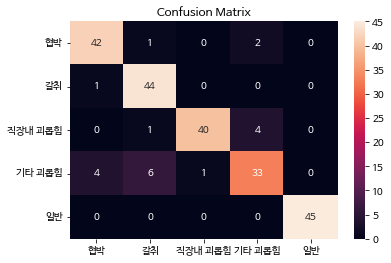

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)
names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘", "일반"]
conf_matrix = pd.DataFrame(conf_matrix, index = names, columns = names)
sns.heatmap(conf_matrix, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
conf_matrix.style.background_gradient(cmap = "summer")

,협박,갈취,직장내 괴롭힘,기타 괴롭힘,일반
협박,42,1,0,2,0
갈취,1,44,0,0,0
직장내 괴롭힘,0,1,40,4,0
기타 괴롭힘,4,6,1,33,0
일반,0,0,0,0,45
